## Classification of Depression on Social Media Using Text Mining

The aim of the project is to predict early signs of depression through **Social Media** text mining.

![img](https://camo.githubusercontent.com/97fa56b4cf5d83227f2f99eec853e56e0e9f87d1/68747470733a2f2f692e6962622e636f2f35764874746e532f62622e706e67)

## Steps

Here are the step-by-step used in this work

### 0. Import packages and define helper functions

In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler, Stream
import csv, json, string, re, time, itertools
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
#from sklearn.metrics import roc_auc_score

def print_x(text):
    print(f'LOG => {text}\n')

### 1. Create a twitter developer account

After creating the developer account you can get the proper keys to be able to download the data.

In [4]:
consumer_key = 'EPINOmoZrP12DET2FJDIAj1pJ'
consumer_secret = '2Jr01uaTuKUVLqkk4NVIzT8D9P7EWo5DfVqejbgsUKZUYhbGlO'
access_token = '816743719143698433-pLpzyZCnbDphHHX6PrtQeMM5dQ0NyBl'
access_secret = 'g9qz34R2HMyc3KPz77tltNcqOUYcSI3TpHgV7brOfCDmf'

### 2. Download data

Use the credentials to download the current tweets using keywords such as depression, anxiety or sadness.

Below you can see some of the tweets.

In [6]:
class StdOutListener(StreamListener):
    def __init__(self):
        super().__init__()
        self.tweet_count = 0
        self.tweets_limit = 10000
        
    def on_data(self, data):
        with open('data/tweetdata.txt','a') as tf:
            tf.write(data)
        print_x(data)
        self.tweet_count += 1
        if self.tweet_count < self.tweets_limit:
            return True
        else:
            stream.disconnect()

    def on_error(self, status):
        print_x(status)

l = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
stream = Stream(auth, l)
stream.filter(track=['depression', 'anxiety', 'mental health', 'suicide', 'stress', 'sad'])

LOG => {"created_at":"Sun Jun 30 18:17:26 +0000 2019","id":1145395936392298496,"id_str":"1145395936392298496","text":"\ud83d\ude2d\ud83d\ude2d\ud83d\ude2d\ud83d\ude2d","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":954729067990929408,"id_str":"954729067990929408","name":"M.P","screen_name":"SmangaMP","location":null,"url":null,"description":"Don't forget to spread love \ud83d\udc95","translator_type":"none","protected":false,"verified":false,"followers_count":207,"friends_count":157,"listed_count":1,"favourites_count":5639,"statuses_count":4329,"created_at":"Sat Jan 20 14:55:22 +0000 2018","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_color"

LOG => {"created_at":"Sun Jun 30 18:30:26 +0000 2019","id":1145399209027411970,"id_str":"1145399209027411970","text":"RT @sgreene_98: Elementary: Zoologist\nMiddle: Teacher \nHigh school: MLB General Manager\nCollege: Something with accounting &amp; sports eventua\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":375907186,"id_str":"375907186","name":"Shelby Taylor","screen_name":"lilkayswag16","location":null,"url":null,"description":"#KSU #EMAW","translator_type":"none","protected":false,"verified":false,"followers_count":497,"friends_count":781,"listed_count":2,"favourites_count":879,"statuses_count":6427,"created_at":"Sun Sep 18 23:28:55 +0000 2011","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contribut

### 3. Relating the data set with a dictionary of words with polarity (essential to calculating the sentiment of each tweet).

In [10]:
tweets_data, x, y, k, some_milby = [], [], [], [], []

def getdata(dataurl):
    print_x("Retrieving TXT File")
    tweets_data_path = dataurl
    tweets_file = open(tweets_data_path, "r")
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except:
            continue
    print_x("Retrieving Successfull")
    time.sleep(3)
    processdata()


def processdata():
    print_x("Recovering Data Teets")
    time.sleep(1)
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    for i in range(len(tweets_data)):
        q = tweets_data[i]['text']
        o = tweets_data[i]['id_str']
        q = RE_EMOJI.sub(r'', q)
        i = q.translate(str.maketrans('', '', string.punctuation))
        x.append(i)
        k.append(o)
    print_x("Data Tweets Recovered")


def readdict(dataurl):
    print_x("Reading Dictionary")
    with open(dataurl) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            i = []
            i.append(row[2])
            i.append(row[5])
            y.append(i)
    print_x("Dictionary Preparation Done")
    addpolarity()


def addpolarity():
    start_time = time.time()
    counter, sum_more = 0, 0
    print_x("Processing please wait...")

    for j in x:
        tweet_token = j
        token = word_tokenize(tweet_token)
        sumnum = 0
        sum_word = 0
        for t in token:
            for d in y:
                if t == d[0]:
                    sentiment = d[1]
                    if sentiment == "positive":
                        sumnum += 1
                        sum_word += 1

                    elif sentiment == "negative":
                        sumnum += -1
                        sum_word += 1

                    else:
                        sumnum += 0
                        sum_word += 1
                    break

        if sum_word != 0.0:
            sum_more = sumnum / sum_word
            if sum_more >= 0.2:
                sum_more = 1
            elif (sum_more < 0.2) and (sum_more > -0.5):
                sum_more = 0
            elif sum_more <= -0.5:
                sum_more = -1
            else:
                print_x("****")

        sum_var = []
        varid = k[counter]
        sum_var.append(varid)
        sum_var.append(sum_more)
        some_milby.append(sum_var)
        counter += 1

    print_x("Processing time: " + str(round(
        (time.time() - start_time), 8)) + "Seconds",)

    time.sleep(3)

    print_x("Processing Finish")
    savetoxlsx()


def savetoxlsx():
    df = pd.DataFrame(some_milby)
    df.to_excel(
        'data/processed_output.xlsx',
        header=("id", "sentiment"), 
        index=False,
    )
    print_x("Data Saved!")


def runall():
    getdata('data/tweetdata.txt')
    readdict('data/dictionary.tsv')


runall()

LOG => Retrieving TXT File

LOG => Retrieving Successfull

LOG => Recovering Data Teets

LOG => Data Tweets Recovered

LOG => Reading Dictionary

LOG => Dictionary Preparation Done

LOG => Processing please wait...

LOG => Processing time: 61.57729864Seconds

LOG => Processing Finish

LOG => Data Saved!



### 4. Now we have each tweet and the corresponding sentiment filtered by depressive keywords (Positive, Neutral and Negative).

### 5. Now let's start training and predicting. The code will walk through the *processed_output.xlsx* file getting the tweet and the id of each sentiment. Then with the id we get the original data and feed the classifiers.

In [2]:
tweets_data, x, y = [], [], []
vectorizer = CountVectorizer(stop_words='english')


def retrieveTweet(data_url):
    tweets_data_path = data_url
    tweets_file = open(tweets_data_path, "r")
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except:
            continue


def retrieveProcessedData(Pdata_url):
    sent = pd.read_excel(Pdata_url)
    for i in range(len(tweets_data)):
        if tweets_data[i]['id'] == sent['id'][i]:
            x.append(tweets_data[i]['text'])
            y.append(sent['sentiment'][i])

def plot(actual, predictions, string):
    nb_matrix = confusion_matrix(actual, predictions)
    plt.figure()
    plot_confusion_matrix(
        nb_matrix, classes=[-1, 0, 1], 
        title=f'Confusion matrix For {string}',
    )

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def nbTrain():
    from sklearn.naive_bayes import MultinomialNB
    start_timenb = time.time()
    train_features = vectorizer.fit_transform(x)

    actual = y

    nb = MultinomialNB()
    nb.fit(train_features, [int(r) for r in y])

    test_features = vectorizer.transform(x)
    predictions = nb.predict(test_features)
    fpr, tpr, thresholds = metrics.roc_curve(actual, predictions, pos_label=1)
    nbscore = format(metrics.auc(fpr, tpr))
    nbscore = float(nbscore)*100

    plot(actual, predictions, 'NB classifier')

    print_x("Naive Bayes  Accuracy : " + str(nbscore) + "%")
    print_x(" Completion Speed" + str(round((time.time() - start_timenb), 5)))


def datree():
    from sklearn import tree
    start_timedt = time.time()
    train_featurestree = vectorizer.fit_transform(x)
    actual1 = y
    test_features1 = vectorizer.transform(x)
    dtree = tree.DecisionTreeClassifier()

    dtree = dtree.fit(train_featurestree, [int(r) for r in y])

    prediction1 = dtree.predict(test_features1)
    ddd, ttt, thresholds = metrics.roc_curve(actual1, prediction1, pos_label=1)
    dtreescore = format(metrics.auc(ddd, ttt))
    dtreescore = float(dtreescore)*100
    
    plot(actual1, prediction1, 'datree classifier')
    
    print_x("Decision tree Accuracy : " + str(dtreescore) + "%")
    print_x(" Completion Speed" + str(round((time.time() - start_timedt), 5)))

def Tsvm():
    from sklearn.svm import SVC
    start_timesvm = time.time()
    train_featuressvm = vectorizer.fit_transform(x)
    actual2 = y
    test_features2 = vectorizer.transform(x)
    svc = SVC(gamma='scale')

    svc = svc.fit(train_featuressvm, [int(r) for r in y])
    prediction2 = svc.predict(test_features2)
    sss, vvv, thresholds = metrics.roc_curve(actual2, prediction2, pos_label=1)
    svc = format(metrics.auc(sss, vvv))
    svc = float(svc)*100
    
    plot(actual2, prediction2, 'SVC classifier')
    
    print_x("Support vector machine Accuracy : " + str(svc) + "%")
    print_x(" Completion Speed" + str(round((time.time() - start_timesvm), 5)))


def knN():
    from sklearn.neighbors import KNeighborsClassifier
    start_timekn = time.time()
    train_featureskn = vectorizer.fit_transform(x)
    actual3 = y
    test_features3 = vectorizer.transform(x)
    kn = KNeighborsClassifier(n_neighbors=2)

    kn = kn.fit(train_featureskn, [int(i) for i in y])
    prediction3 = kn.predict(test_features3)
    kkk, nnn, thresholds = metrics.roc_curve(actual3, prediction3, pos_label=1)
    kn = format(metrics.auc(kkk, nnn))
    kn = float(kn)*100
    
    plot(actual3, prediction3, 'knN classifier')

    print_x("Kneighborsclassifier Accuracy : " + str(kn) + "%")
    print_x(" Completion Speed" + str(round((time.time() - start_timekn), 5)))


def RanFo():
    from sklearn.ensemble import RandomForestClassifier
    start_timerf = time.time()
    train_featuresrf = vectorizer.fit_transform(x)
    actual4 = y
    test_features4 = vectorizer.transform(x)
    rf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100)

    rf = rf.fit(train_featuresrf, [int(i) for i in y])
    prediction4 = rf.predict(test_features4)
    rrr, fff, thresholds = metrics.roc_curve(actual4, prediction4, pos_label=1)
    kn = format(metrics.auc(rrr, fff))
    kn = float(kn)*100
    
    plot(actual4, prediction4, 'Random Forest classifier')
    
    print_x("Random Forest Accuracy : " + str(kn) + "%")
    print_x(" Completion Speed" + str(round((time.time() - start_timerf), 5)))
    
def run(function):
    global tweets_data, x, y
    tweets_data, x, y = [], [], []
    retrieveTweet('data/tweetdata.txt')
    retrieveProcessedData('data/processed_output.xlsx')
    function()

LOG => Naive Bayes  Accuracy : 91.53779792375414%

LOG =>  Completion Speed0.46298



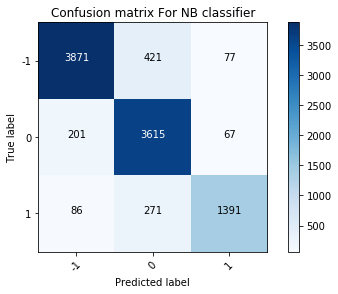

In [43]:
run(nbTrain)

LOG => Decision tree Accuracy : 96.9452346896557%

LOG =>  Completion Speed1.98457



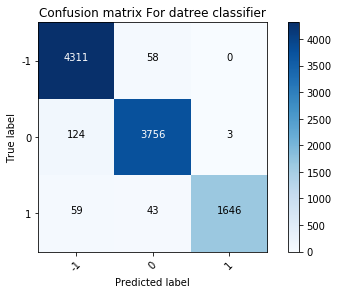

In [3]:
run(datree)

LOG => Support vector machine Accuracy : 61.345505589935335%

LOG =>  Completion Speed27.42514



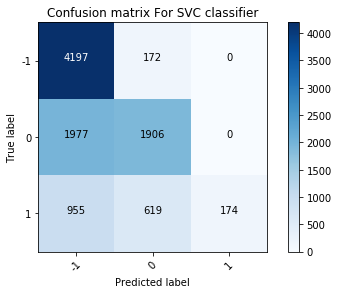

In [49]:
run(Tsvm)

LOG => Kneighborsclassifier Accuracy : 78.11964106059581%

LOG =>  Completion Speed2.80292



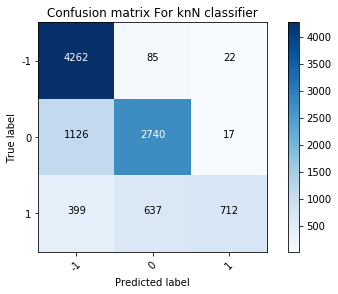

In [50]:
run(knN)

LOG => Random Forest Accuracy : 46.88222035626063%

LOG =>  Completion Speed0.55773



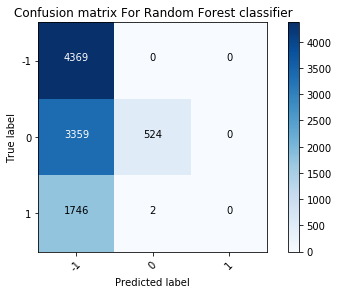

In [53]:
run(RanFo)

6. But one more thing! We have now also the ability to wrote a tweet and check how it performs through the model we made!

`stream.filter(track=['depression', 'anxiety', 'mental health', 'suicide', 'stress', 'sad'])`

In [4]:
def datreeINPUT(inputtweet):
    from sklearn import tree
    train_featurestree = vectorizer.fit_transform(x)
    dtree = tree.DecisionTreeClassifier()

    dtree = dtree.fit(train_featurestree, [int(r) for r in y])

    inputdtree = vectorizer.transform([inputtweet])
    predictt = dtree.predict(inputdtree)

    if predictt == 1:
        predictt = "Positive"
    elif predictt == 0:
        predictt = "Neutral"
    elif predictt == -1:
        predictt = "Negative"
    else:
        print("Nothing")

    print_x(f'predictt: {predictt}')
    
print("Input your tweet : ")
inputtweet = input()

datreeINPUT(inputtweet)

Input your tweet : 
I'm feeling good!
LOG => predictt: Positive



### What about the results?

#### Positive
This mean that the person is unlikely to have depression or anxiety.

#### Neutral
This is the middle level wherein the user may or may not have depression but may also be more prone to being depress. At that stage the user may display some depressino symptoms.

#### Negative
Is the lowest level where depression and anxiety symptoms are being detected through the users tweets. The more negative words the user uses mean the more negative emotion the tweet has.

### References

Ma, Long & Wang, Zhibo & Zhang, Yanqing. (2017). Extracting Depression Symptoms from Social Networks and Web Blogs via Text Mining. 325-330. 10.1007/978-3-319-59575-7_29.

https://github.com/niquejoe/Classification-of-Depression-on-Social-Media-Using-Text-Mining